In [1150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.stats as st

In [1151]:
matchesSpain = pd.read_csv('data/matches_Spain.csv')
matchesItaly = pd.read_csv('data/matches_Italy.csv')
matchesGermany = pd.read_csv('data/matches_Germany.csv')
matchesFrance= pd.read_csv('data/matches_France.csv')
matchesEngland = pd.read_csv('data/matches_England.csv')

In [1152]:
matches=pd.concat((matchesEngland,matchesSpain,matchesItaly,matchesGermany,matchesFrance), axis=0)

In [1153]:
len(matches)==len(matchesEngland)+len(matchesSpain)+len(matchesItaly)+len(matchesGermany)+len(matchesFrance)

True

In [1154]:
matches[['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation']].drop_duplicates()

,status,duration,team1.scoreET,team1.scoreP,team1.hasFormation,team2.scoreET,team2.scoreP,team2.hasFormation
0,Played,Regular,0,0,1,0,0,1


In [1155]:
matches.drop(['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation'],
             axis=1, inplace=True)

In [1156]:
matches.drop(['roundId','seasonId'],
             axis=1, inplace=True)

In [1157]:
matches.columns

Index(['gameweek', 'teamsData', 'dateutc', 'winner', 'venue', 'wyId', 'label',
       'date', 'referees', 'competitionId', 'team1.coachId', 'team1.side',
       'team1.teamId', 'team1.score', 'team1.formation', 'team1.scoreHT',
       'team1.formation.bench', 'team1.formation.lineup',
       'team1.formation.substitutions', 'team2.coachId', 'team2.side',
       'team2.teamId', 'team2.score', 'team2.formation', 'team2.scoreHT',
       'team2.formation.bench', 'team2.formation.lineup',
       'team2.formation.substitutions'],
      dtype='object')

Also dropping a lot of additional columns for my initial ML model. 

In [1158]:
matches.drop(['teamsData',   'venue', 
                'date', 'referees', 'team1.coachId', 
                'team1.formation', 'team1.scoreHT',
                'team1.formation.bench', 'team1.formation.lineup',
                'team1.formation.substitutions', 'team2.coachId',
                'team2.formation', 'team2.scoreHT',
                'team2.formation.bench', 'team2.formation.lineup',
                'team2.formation.substitutions'],
            axis=1, inplace=True)


In [1159]:
matches=matches.sort_values(by=['dateutc','wyId']).reset_index(drop=True)

In [1160]:
matches

,gameweek,dateutc,winner,wyId,label,competitionId,team1.side,team1.teamId,team1.score,team2.side,team2.teamId,team2.score
0,1,2017-08-04 18:45:00,19830,2500691,"Monaco - Toulouse, 3 - 2",412,away,3780,2,home,19830,3
1,1,2017-08-05 15:15:00,3767,2500693,"PSG - Amiens SC, 2 - 0",412,home,3767,2,away,3789,0
2,1,2017-08-05 18:00:00,3766,2500688,"Olympique Lyonnais - Strasbourg, 4 - 0",412,home,3766,4,away,3779,0
3,1,2017-08-05 18:00:00,3785,2500690,"Metz - Guingamp, 1 - 3",412,home,3777,1,away,3785,3
4,1,2017-08-05 18:00:00,3787,2500692,"Montpellier - Caen, 1 - 0",412,away,3783,0,home,3787,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,38,2018-05-20 16:00:00,3204,2576337,"SPAL - Sampdoria, 3 - 1",524,away,3164,1,home,3204,3
1822,38,2018-05-20 16:30:00,0,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2",795,home,679,2,away,701,2
1823,38,2018-05-20 18:45:00,676,2565922,"Barcelona - Real Sociedad, 1 - 0",795,home,676,1,away,687,0
1824,38,2018-05-20 18:45:00,3161,2576335,"Lazio - Internazionale, 2 - 3",524,home,3162,2,away,3161,3


##### Now I want to replace the winner, team1.teamId, team2.teamId with the team names.

Creating a team mapping dictionary

In [1161]:
teams=pd.read_csv('data/teams.csv')
team_mapping=teams.set_index('wyId')['name'].to_dict()

In [1162]:
matches['team1.teamId']=matches['team1.teamId'].map(team_mapping)
matches['team2.teamId']=matches['team2.teamId'].map(team_mapping)
matches['winner']=matches['winner'].map(team_mapping)

In [1163]:
matches.rename(columns={'team1.teamId':'team1.teamName','team2.teamId':'team2.teamName'}, inplace=True)

#### I want all home teams on the left, all the away teams on the right. And I want it labeled home and away instead of team1 and team2

(as was done in the feature planning file)

In [1164]:
home_teams1 = matches[matches['team1.side'] == 'home'].copy()
home_teams1 = home_teams1[['team1.side', 'team1.teamName', 'team1.score']]
home_teams1.columns=['home.side', 'home.teamName', 'home.score']

home_teams2 = matches[matches['team2.side'] == 'home'].copy()
home_teams2 = home_teams2[['team2.side', 'team2.teamName', 'team2.score']]
home_teams2.columns = ['home.side', 'home.teamName', 'home.score']

home_teams=pd.concat([home_teams1, home_teams2], axis=0).sort_index()

In [1165]:
away_teams1 = matches[matches['team1.side'] == 'away'].copy()
away_teams1 = away_teams1[['team1.side', 'team1.teamName', 'team1.score']]
away_teams1.columns=['away.side', 'away.teamName', 'away.score']

away_teams2 = matches[matches['team2.side'] == 'away'].copy()
away_teams2 = away_teams2[['team2.side', 'team2.teamName', 'team2.score']]
away_teams2.columns = ['away.side', 'away.teamName', 'away.score']

away_teams=pd.concat([away_teams1, away_teams2], axis=0).sort_index()

In [1166]:
match_cols = matches[['competitionId','gameweek','wyId', 'dateutc', 'winner', 'label']]

In [1167]:
matches = pd.concat([match_cols , home_teams, away_teams], axis = 1)

In [1168]:
matches.head()

,competitionId,gameweek,wyId,dateutc,winner,label,home.side,home.teamName,home.score,away.side,away.teamName,away.score
0,412,1,2500691,2017-08-04 18:45:00,Monaco,"Monaco - Toulouse, 3 - 2",home,Monaco,3,away,Toulouse,2
1,412,1,2500693,2017-08-05 15:15:00,PSG,"PSG - Amiens SC, 2 - 0",home,PSG,2,away,Amiens SC,0
2,412,1,2500688,2017-08-05 18:00:00,Olympique Lyonnais,"Olympique Lyonnais - Strasbourg, 4 - 0",home,Olympique Lyonnais,4,away,Strasbourg,0
3,412,1,2500690,2017-08-05 18:00:00,Guingamp,"Metz - Guingamp, 1 - 3",home,Metz,1,away,Guingamp,3
4,412,1,2500692,2017-08-05 18:00:00,Montpellier,"Montpellier - Caen, 1 - 0",home,Montpellier,1,away,Caen,0


### Some grouping to get the average goals scored

##### grouping by match and home team

In [1169]:
numHomeGoals=matches.groupby(['dateutc','wyId','home.teamName'])['home.score'].first().reset_index()
numHomeGoals.rename(columns={'home.teamName':'teamName','home.score':'NumGoals'}, inplace=True)

##### grouping by match and away team

In [1170]:
numAwayGoals=matches.groupby(['dateutc','wyId','away.teamName'])['away.score'].first().reset_index()
numAwayGoals.rename(columns={'away.teamName':'teamName','away.score':'NumGoals'}, inplace=True)


In [1171]:
allgoals=pd.concat([numHomeGoals,numAwayGoals],axis=0).sort_values(by="dateutc")

In [1172]:
# Calculate cumulative mean excluding the current row's goals
allgoals['GoalsPerGame'] = allgoals.groupby('teamName')['NumGoals'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)


In [1173]:
# Calculate rolling mean over the last 3 rows excluding the current row's goals
allgoals['GoalsPerGame_last3'] = allgoals.groupby('teamName')['NumGoals'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

In [1174]:
matches=matches.merge(
    allgoals, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'GoalsPerGame':'home.GoalsPerGame', 'GoalsPerGame_last3':'home.GoalsPerGame_last3'})

matches.drop(['dateutc_y','teamName','NumGoals'], axis=1, inplace=True)

In [1175]:
matches=matches.merge(
    allgoals, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'GoalsPerGame':'away.GoalsPerGame', 'GoalsPerGame_last3':'away.GoalsPerGame_last3'})

matches.drop(['dateutc_y','teamName','NumGoals'], axis=1, inplace=True)

### Some grouping to get the average goals conceded

In [1176]:
numHomeConceded=matches.groupby(['dateutc','wyId','home.teamName'])['away.score'].first().reset_index()
numHomeConceded.rename(columns={'home.teamName':'teamName','away.score':'NumConceded'}, inplace=True)

In [1177]:
numAwayConceded=matches.groupby(['dateutc','wyId','away.teamName'])['home.score'].first().reset_index()
numAwayConceded.rename(columns={'away.teamName':'teamName','home.score':'NumConceded'}, inplace=True)

In [1178]:
allConceded=pd.concat([numHomeConceded,numAwayConceded],axis=0).sort_values(by="dateutc")

In [1179]:
# Calculate cumulative mean excluding the current row's goals
allConceded['ConcededPerGame'] = allConceded.groupby('teamName')['NumConceded'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)


In [1180]:
# Calculate rolling mean over the last 3 rows excluding the current row's goals
allConceded['ConcededPerGame_last3'] = allConceded.groupby('teamName')['NumConceded'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

In [1181]:
matches=matches.merge(
    allConceded, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'ConcededPerGame':'home.ConcededPerGame', 'ConcededPerGame_last3':'home.ConcededPerGame_last3'})

matches.drop(['dateutc_y','teamName','NumConceded'], axis=1, inplace=True)

In [1182]:
matches=matches.merge(
    allConceded, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'ConcededPerGame':'away.ConcededPerGame', 'ConcededPerGame_last3':'away.ConcededPerGame_last3'})

matches.drop(['dateutc_y','teamName','NumConceded'], axis=1, inplace=True)

In [1183]:
matches[(matches['home.teamName']=='Barcelona')| (matches['away.teamName']=='Barcelona')].head(5)

,competitionId,gameweek,wyId,dateutc,winner,label,home.side,home.teamName,home.score,away.side,away.teamName,away.score,home.GoalsPerGame,home.GoalsPerGame_last3,away.GoalsPerGame,away.GoalsPerGame_last3,home.ConcededPerGame,home.ConcededPerGame_last3,away.ConcededPerGame,away.ConcededPerGame_last3
66,795,1,2565554,2017-08-20 18:15:00,Barcelona,"Barcelona - Real Betis, 2 - 0",home,Barcelona,2,away,Real Betis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,795,2,2565559,2017-08-26 16:15:00,Barcelona,"Deportivo Alav\u00e9s - Barcelona, 0 - 2",home,Deportivo Alav\u00e9s,0,away,Barcelona,2,0.000000,0.000000,2.0,2.000000,1.000000,1.000000,0.0,0.000000
154,795,3,2565577,2017-09-09 18:45:00,Barcelona,"Barcelona - Espanyol, 5 - 0",home,Barcelona,5,away,Espanyol,0,2.000000,2.000000,0.5,0.500000,0.000000,0.000000,1.0,1.000000
192,795,4,2565580,2017-09-16 14:15:00,Barcelona,"Getafe - Barcelona, 1 - 2",home,Getafe,1,away,Barcelona,2,0.666667,0.666667,3.0,3.000000,0.666667,0.666667,0.0,0.000000
231,795,5,2565592,2017-09-19 20:00:00,Barcelona,"Barcelona - Eibar, 6 - 1",home,Barcelona,6,away,Eibar,1,2.750000,3.000000,0.5,0.333333,0.250000,0.333333,1.0,1.333333


In [1184]:
matches.drop(columns=['wyId', 'dateutc','home.side','away.side'], inplace=True)

### updating competition id with the actual competition

In [1185]:
competitions= pd.read_csv('data/competitions.csv')

In [1186]:
competitions.head()

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club


In [1187]:
comp_mapping=competitions.set_index('wyId')['name'].to_dict()

In [1188]:
matches['competition']=matches['competitionId'].map(comp_mapping)

In [1189]:
matches.drop(columns=['competitionId'], inplace=True)

In [1190]:
#rearranging column order

matches=matches[['competition','winner', 'label','gameweek', 'home.teamName', 'home.score', 'away.teamName',
       'away.score', 'home.GoalsPerGame', 'home.GoalsPerGame_last3', 'home.ConcededPerGame',
       'home.ConcededPerGame_last3','away.GoalsPerGame', 'away.GoalsPerGame_last3', 'away.ConcededPerGame',
       'away.ConcededPerGame_last3']]

In [1191]:
matches = matches.copy()

matches['result'] = np.where(matches['winner'] == matches['home.teamName'], 'H',
                        np.where(matches['winner'] == matches['away.teamName'], 'A', 'D'))

In [1192]:
#winner and match labels are no longer needed
matches.drop(columns=['winner','label'], inplace=True)

In [1193]:
#team names and team scores are now no longer needed
matches.drop(columns=['home.teamName','home.score','away.teamName','away.score'], inplace=True)

In [1194]:
#filtering only where gameweek is 6th or more. This is because I am using the results from the last 5 games. 
matches=matches[matches['gameweek']>=4]

In [1195]:
#gameweek
#matches.drop(columns=['gameweek'], inplace=True)

In [1196]:
label_encoder = LabelEncoder()
matches['label'] = label_encoder.fit_transform(matches['result'])

In [1197]:
matches

,competition,gameweek,home.GoalsPerGame,home.GoalsPerGame_last3,home.ConcededPerGame,home.ConcededPerGame_last3,away.GoalsPerGame,away.GoalsPerGame_last3,away.ConcededPerGame,away.ConcededPerGame_last3,result,label
81,French first division,4,3.666667,3.666667,0.666667,0.666667,1.666667,1.666667,0.000000,0.000000,H,2
93,French first division,4,0.333333,0.333333,1.333333,1.333333,3.000000,3.000000,1.333333,1.333333,D,1
99,French first division,4,0.000000,0.000000,2.333333,2.333333,1.000000,1.000000,1.000000,1.000000,H,2
100,French first division,4,2.333333,2.333333,1.666667,1.666667,1.000000,1.000000,1.000000,1.000000,H,2
101,French first division,4,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333,2.000000,2.000000,H,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Italian first division,38,0.972973,2.000000,1.567568,1.000000,1.486486,1.333333,1.540541,1.333333,H,2
1822,Spanish first division,38,1.513514,0.666667,0.540541,0.666667,1.135135,1.666667,1.297297,0.333333,D,1
1823,Spanish first division,38,2.648649,3.666667,0.783784,2.666667,1.783784,2.000000,1.567568,1.333333,H,2
1824,Italian first division,38,2.351351,1.333333,1.243243,1.000000,1.702703,2.333333,0.756757,1.666667,A,0


In [1198]:
features=matches.copy()
features.drop(columns=['result'], inplace=True)

In [1199]:
#train=matches[~matches['competition'].str.contains("English")]
train=features[~(features['competition'].str.contains("English"))]
train=train.copy()
train.drop(columns=['competition','gameweek'], inplace=True)

In [1200]:
#test=matches[matches['competition'].str.contains("English")]
test=features[(features['competition'].str.contains("English"))]
test=test.copy()
test.drop(columns=['competition','gameweek'], inplace=True)

In [1201]:
train[['label']].value_counts().reset_index()

,label,count
0,2,599
1,0,401
2,1,329


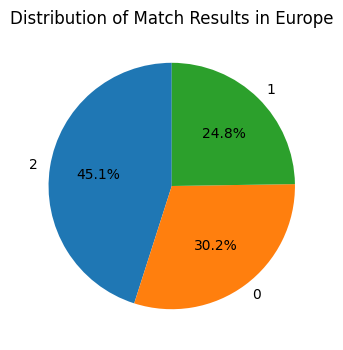

In [1202]:

# Calculate value counts for 'result' column
result_counts = train['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in Europe")
plt.show()


In [1203]:
test[['label']].value_counts().reset_index()

,label,count
0,2,158
1,0,98
2,1,94


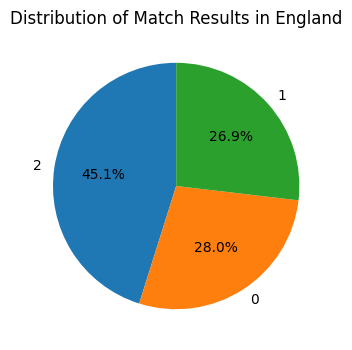

In [1204]:
# Calculate value counts for 'result' column
result_counts = test['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England")
plt.show()


In [1205]:
# Step 1: Prepare data and label encode
# Assuming 'matches' is your DataFrame
X_train = train.drop(columns=['label'])
y_train= train['label']


In [1206]:
# Step 1: Prepare data and label encode
X_test= test.drop(columns=['label'])
y_test= test['label']


In [1207]:
# Step 3: Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Basic RandomForestClassifier

In [1208]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [1209]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.48


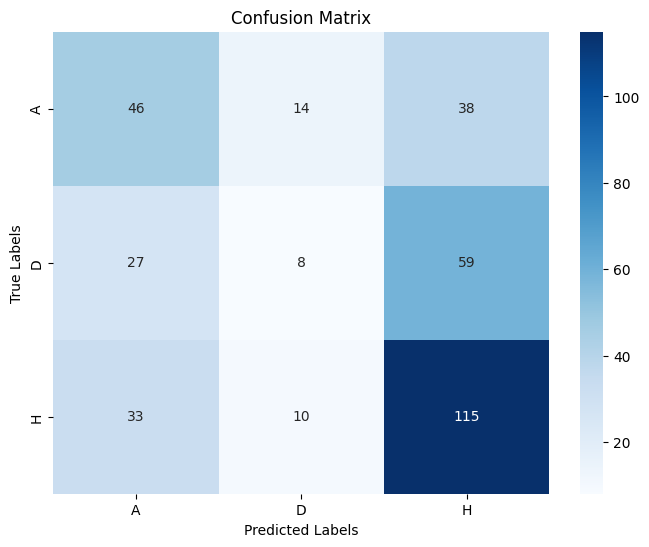

Classification Report:
               precision    recall  f1-score   support

           A       0.43      0.47      0.45        98
           D       0.25      0.09      0.13        94
           H       0.54      0.73      0.62       158

    accuracy                           0.48       350
   macro avg       0.41      0.43      0.40       350
weighted avg       0.43      0.48      0.44       350



In [1210]:



# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


In [1067]:
#%%time
##Took 7 minutes to run
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'criterion': ['gini', 'entropy']
#}

#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
#grid_search.fit(X_train, y_train)
#print(f'Best Parameters: {grid_search.best_params_}')

In [1068]:
model = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [1069]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.54


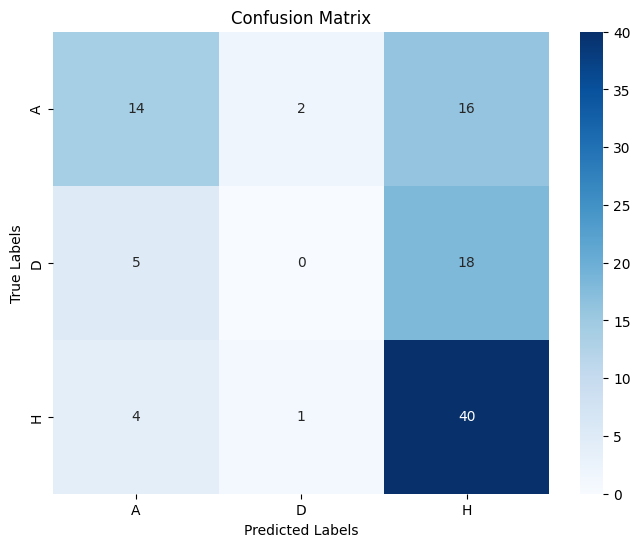

Classification Report:
               precision    recall  f1-score   support

           A       0.61      0.44      0.51        32
           D       0.00      0.00      0.00        23
           H       0.54      0.89      0.67        45

    accuracy                           0.54       100
   macro avg       0.38      0.44      0.39       100
weighted avg       0.44      0.54      0.47       100



In [1070]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


### Basic XGBoost

In [1211]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1212]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        98
           1       0.28      0.18      0.22        94
           2       0.55      0.66      0.60       158

    accuracy                           0.47       350
   macro avg       0.43      0.43      0.42       350
weighted avg       0.45      0.47      0.46       350



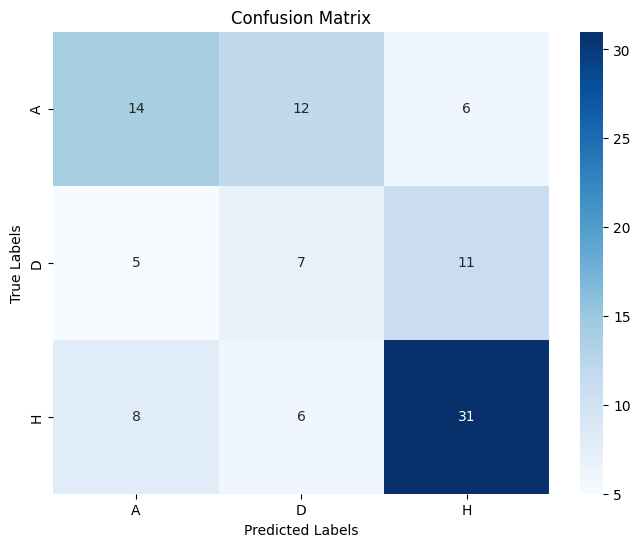

Classification Report:
               precision    recall  f1-score   support

           A       0.52      0.44      0.47        32
           D       0.28      0.30      0.29        23
           H       0.65      0.69      0.67        45

    accuracy                           0.52       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.52      0.52      0.52       100



In [1073]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


### GridSearch XGBoost

In [1093]:
#%%time
##takes about 80 seconds

## Define the parameter grid
#param_dist = {
#    'n_estimators': [100, 200, 300],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'max_depth': st.randint(3, 15),
#    'subsample': [0.8, 0.9, 1.0],
#    'colsample_bytree': [0.8, 0.9, 1.0]
#}

## Create XGBoost classifier
#model = xgb.XGBClassifier()

## RandomizedSearchCV
#random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)
#random_search.fit(X_train, y_train)

# Get best parameters
#print("Best Parameters:", random_search.best_params_)

In [1213]:
# Initialize the model with the best parameters
model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    subsample=1
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1214]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.52      0.50        98
           1       0.33      0.01      0.02        94
           2       0.52      0.79      0.63       158

    accuracy                           0.51       350
   macro avg       0.44      0.44      0.38       350
weighted avg       0.46      0.51      0.43       350



In [1215]:
# Get the predicted probabilities for each class
y_pred_proba = model.predict_proba(X_test)
# Get the maximum confidence level for each prediction
confidence_levels = np.max(y_pred_proba, axis=1)

In [1216]:
proba_df = pd.DataFrame(y_pred_proba, columns=['prob_A', 'prob_D', 'prob_H'])


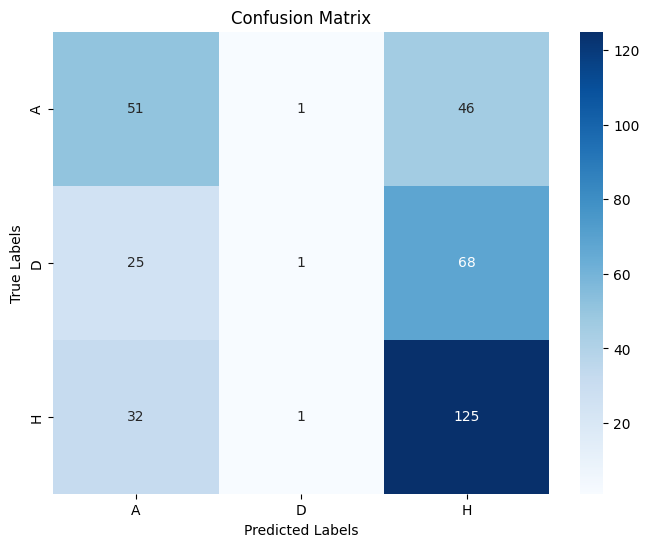

Classification Report:
               precision    recall  f1-score   support

           A       0.47      0.52      0.50        98
           D       0.33      0.01      0.02        94
           H       0.52      0.79      0.63       158

    accuracy                           0.51       350
   macro avg       0.44      0.44      0.38       350
weighted avg       0.46      0.51      0.43       350



In [1217]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


In [1081]:
train.drop(columns=['label'], inplace=True)

### Feature Importance

In [1083]:
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'feature': train.columns, 'importance': feature_importances})
features_df = features_df.sort_values(by='importance', ascending=False)
print(features_df)

                      feature  importance
4           away.GoalsPerGame    0.257656
0           home.GoalsPerGame    0.180439
6        away.ConcededPerGame    0.146925
2        home.ConcededPerGame    0.103252
1     home.GoalsPerGame_last3    0.101347
3  home.ConcededPerGame_last3    0.074041
5     away.GoalsPerGame_last3    0.072822
7  away.ConcededPerGame_last3    0.063518


In [908]:
temp=matchesEngland[matchesEngland['gameweek']>28]

temp=temp.copy()
temp.sort_values(by=['dateutc','wyId'], inplace=True)


In [909]:
temp['predictions']=label_encoder.inverse_transform(y_pred)

In [910]:
temp['confidence']=confidence_levels


In [911]:
temp = temp.reset_index(drop=True).join(proba_df)

In [913]:
temp[temp['predictions']=="D"]

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,...,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions,predictions,confidence,prob_A,prob_D,prob_H
83,Played,4405654,37,"{'1612': {'scoreET': 0, 'coachId': 14791, 'sid...",181150,2018-05-06 15:30:00,1610,Stamford Bridge,2500082,"Chelsea - Liverpool, 1 - 0",...,"{'bench': [{'playerId': 3551, 'ownGoals': '2',...",1,"[{'playerId': 3551, 'ownGoals': '2', 'redCards...","[{'playerId': 25707, 'ownGoals': '2', 'redCard...","[{'playerIn': 105333, 'playerOut': 25707, 'min...",D,0.345392,0.325699,0.345392,0.328909


In [638]:
temp[temp['predictions']=="D"]

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,...,team2.score,team2.scoreP,team2.hasFormation,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions,predictions,confidence
66,Played,4405654,32,"{'1610': {'scoreET': 0, 'coachId': 272869, 'si...",181150,2018-04-01 15:00:00,1624,Stamford Bridge,2500031,"Chelsea - Tottenham Hotspur, 1 - 3",...,3,0,1,"{'bench': [{'playerId': 40765, 'ownGoals': '0'...",1,"[{'playerId': 40765, 'ownGoals': '0', 'redCard...","[{'playerId': 14911, 'ownGoals': '0', 'redCard...","[{'playerIn': 8717, 'playerOut': 14911, 'minut...",D,0.350985


In [1090]:
temp[temp['confidence']>=0.75]

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,...,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions,predictions,confidence,prob_A,prob_D,prob_H
87,Played,4405654,31,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-09 19:00:00,1625,Etihad Stadium,2500024,"Manchester City - Brighton & Hove Albion, 3 - 1",...,"{'bench': [{'playerId': 283145, 'ownGoals': '0...",2,"[{'playerId': 283145, 'ownGoals': '0', 'redCar...","[{'playerId': 241564, 'ownGoals': '2', 'redCar...","[{'playerIn': 26136, 'playerOut': 241564, 'min...",H,0.754691,0.106859,0.13845,0.754691


### My first models are achieving about 50% accuracy and pretty bad recall for Draw results.

I am going to engineer a few more features now 

Some feature I will now get from the matches data:
- Form. W/D/L in the last 5 games
- Home v Away Season performance
- Time passed sinc the last match they played
- Half time score in the last 3 games

In [1094]:
#I will continue this on a new notebook